# Aggregation of Power Systems Optimization Models - Part I

Consider the following model:

![alt text](img/model.png "Model")

The goal is to find $r$ such that $|r|<<|h|$ but keeping results as close as posible to those obtained with $h$.

In the following cells an example is shown using a testbed using **Pyomo** to run aggregated and complete versions of this model.


In [1]:
import matplotlib.pyplot as plt
import openpyxl
import os
import pandas as pd
import pyomo.environ as pyo
import seaborn as sns
import testbed

from sklearn.cluster import KMeans          # sklearn is a library used for machine learning models
from sklearn_extra.cluster import KMedoids  # sklearn_extra is an extension of sklearn with additional machine learning algorithms

from importlib import reload
import warnings
warnings.filterwarnings(action='ignore')     # if getting some boring warnings


In [2]:
# We can export the variables, first create a folder and then export the results
slvr = 'gurobi'     # change according to the solver installed in your machine
reload(testbed)
results_complete = testbed.run_complete_case(folder='data', case='complete_single_node.xlsx', solver=slvr)

df_complete, df_hourly = testbed.export_complete_solution(results_complete, 'complete_single_node')
df_complete



,complete
of_value,7.000903e+08
thermal,2.378023e+06
renewable,1.244741e+06
nsp,1.278567e+05


In [3]:
# extracting the duals
df_complete_duals = testbed.extract_duals(results_complete, 'complete_single_node')
df_complete_duals

,period,eBalance,eNSP,eMinProd_t1,eMinProd_w1,eMaxProd_t1,eMaxProd_w1
0,1,24.0,0.0,0.0,0.0,0.0,-21.0
1,2,24.0,0.0,0.0,0.0,0.0,-21.0
2,3,24.0,0.0,0.0,0.0,0.0,-21.0
3,4,3.0,0.0,0.0,0.0,0.0,0.0
4,5,3.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
8731,8732,24.0,0.0,0.0,0.0,0.0,-21.0
8732,8733,24.0,0.0,0.0,0.0,0.0,-21.0
8733,8734,24.0,0.0,0.0,0.0,0.0,-21.0
8734,8735,24.0,0.0,0.0,0.0,0.0,-21.0


## Data Wrangling and Exploration
Let us load the input space of the model, time to practice a little of data wrangling and plotting.

In [4]:
df_cf = pd.read_excel(os.path.join('data', 'complete_single_node.xlsx'), sheet_name='cap_factors')
df_demand = pd.read_excel(os.path.join('data', 'complete_single_node.xlsx'), sheet_name='demand')

In [5]:
df_demand.head()

,period,demand
0,1,363.727832
1,2,319.511974
2,3,250.935275
3,4,182.028803
4,5,130.522977


In [6]:
df_cf.head()

,period,generator,cap_factor
0,1,w1,0.35
1,2,w1,0.38
2,3,w1,0.41
3,4,w1,0.47
4,5,w1,0.53


In [7]:
# we don't need the generator column for this example so let us remove it
df_cf.drop(columns=['generator'], inplace=True)
df_cf.head()

,period,cap_factor
0,1,0.35
1,2,0.38
2,3,0.41
3,4,0.47
4,5,0.53


In [8]:
# join the dataframes and plot the input data of the model
df_input = pd.merge(left=df_demand, left_on='period', right=df_cf, right_on='period')
df_input.head()

,period,demand,cap_factor
0,1,363.727832,0.35
1,2,319.511974,0.38
2,3,250.935275,0.41
3,4,182.028803,0.47
4,5,130.522977,0.53


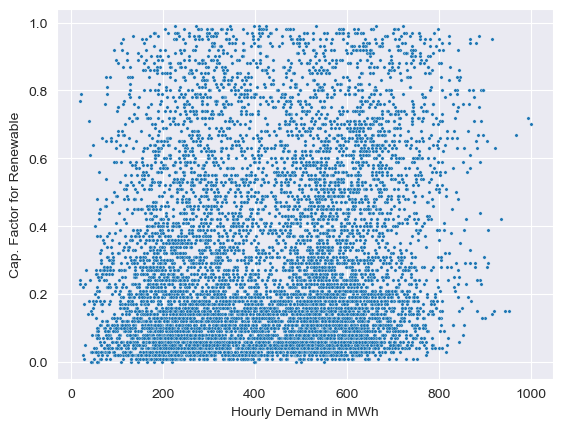

In [9]:
ax = sns.scatterplot(df_input, x='demand', y='cap_factor', s=6)
ax.set_ylabel('Cap. Factor for Renewable')
ax.set_xlabel('Hourly Demand in MWh')
plt.show()


## Clustering the Input Data
Now let us take the input data and cluster it using the good old k-Means. Look at the clustering notebook for the details; also note that in this case the data isn't normalized nor scaled, so we must transform it. We'll leave the Capacity Factors as they are and just scale the demand with its maximum value, though this doesn't mean that this is the best choice. In clustering models, data normalization is a topic of its own, like representative selection or the number of clusters.

In [10]:
df_input['demand_scaled'] = df_input['demand'] / df_input['demand'].max()
clusterer = KMeans(n_clusters = 3, random_state = 50, max_iter = 1000, n_init = 'auto')
# clusterer = KMedoids(n_clusters = 3, random_state = 50, max_iter = 1000)


df_input_clust = df_input.loc[:, ['cap_factor', 'demand_scaled']].copy()
clusterer.fit(df_input_clust)

df_input_clust["labels"] = clusterer.labels_ + 1

df_centroids = pd.DataFrame(clusterer.cluster_centers_[:, 0:2])
df_centroids.columns = ['cap_factor', 'demand']
df_centroids

,cap_factor,demand
0,0.160507,0.246573
1,0.684842,0.477227
2,0.164836,0.579690


This centroid don't make sense for the demand, we need to 'reverse' the scaling

In [11]:
df_centroids['demand'] = df_centroids['demand'] * df_input['demand'].max()
df_centroids

,cap_factor,demand
0,0.160507,246.572550
1,0.684842,477.227212
2,0.164836,579.689729


Time to add the *weights*

In [12]:
weights = df_input_clust.groupby('labels').count().reset_index(drop=True).loc[:, 'cap_factor']
weights.rename('weight', inplace=True)
df_centroids = pd.merge(left=df_centroids, right=weights, left_index=True, right_index=True)
df_centroids

,cap_factor,demand,weight
0,0.160507,246.572550,3188
1,0.684842,477.227212,2447
2,0.164836,579.689729,3101


## Aggregated model
Time to run the aggregated model, configure the Excel file as indicated in the picture.
The code is configured to used *aggregated_single/config.xlsx* as the default location, but you can specify your own

![alt text](img/config_agg.png "Model")


In [13]:
# config file can also be auto generated
df_config = testbed.generate_config(df_centroids, folder='aggregated_single')
df_config

,basis,centroid_demand,centroid_cf,weight
0,bs_auto1,246.572550,0.160507,3188
1,bs_auto2,477.227212,0.684842,2447
2,bs_auto3,579.689729,0.164836,3101


In [14]:
results = testbed.basis_execution(folder=os.path.join('data', 'aggregated_single'), # location of the aggregated model
                                  solver=slvr, file='config_auto.xlsx')             # configuration file with aggregation information

# results = testbed.basis_execution(folder=os.path.join('data', 'aggregated_single'), # location of the aggregated model
#                                   solver=slvr, file='config.xlsx')                  # configuration file with aggregation information

df_agg = testbed.export_aggregated_solution(results, 'aggregated_single')
df_comparison = testbed.export_model_comparison(df_complete, df_agg)

In [15]:
df_agg

,basis,of_value,thermal,renewable,nsp,weight
0,bs_auto1,1.349294e+07,5.302246e+05,255848.731600,0.0,3188
1,bs_auto2,1.043061e+07,3.298706e+05,837904.368594,0.0,2447
2,bs_auto3,3.777570e+07,1.542040e+06,255577.746456,0.0,3101


In [16]:
df_comparison

,result,complete,aggregated,delta,rel_delta
0,of_value,7.000903e+08,6.169924e+07,6.383911e+08,0.911870
1,thermal,2.378023e+06,2.402135e+06,-2.411240e+04,-0.010140
2,renewable,1.244741e+06,1.349331e+06,-1.045902e+05,-0.084026
3,nsp,1.278567e+05,0.000000e+00,1.278567e+05,1.000000
4,decision_vars,2.620800e+04,9.000000e+00,2.619900e+04,0.999657


## Extreme Periods
A lot of research has shown the importance of extreme periods in the approximation of aggregated Power System Optimization Models, in this case, let us identify the period with the highest hourly cost

In [17]:
hourly_cost = []
periods = []

for x in results_complete.vCost:
    hourly_cost.append(pyo.value(results_complete.vCost[x]))
    periods.append(int(x))

df_cost = pd.DataFrame({'period': periods, 'hourly_cost': hourly_cost})
# express cost in relative terms with the respect to the highest
df_cost['rel_hourly_cost'] = df_cost['hourly_cost'] / df_cost['hourly_cost'].max()
# let us join the cost data with the inputs
df_input = pd.merge(left=df_input, left_on='period', right=df_cost, right_on='period')


In [18]:
ext_period = df_input['hourly_cost'].argmax() + 1 # plus one because it returns index position, which begins at zero
ext_period

8443

In [19]:
# this period should be added to your config file with weight of one
df_input[df_input.period == ext_period]

,period,demand,cap_factor,demand_scaled,hourly_cost,rel_hourly_cost
8442,8443,952.18123,0.15,0.952181,1898131.15,1.0


So now we have to cluster all the other periods leaving out our approximation of an *extreme*

In [20]:
clusterer = KMeans(n_clusters = 3, random_state = 50, max_iter = 1000, n_init = 'auto')
# clusterer = KMedoids(n_clusters = 3, random_state = 50, max_iter = 1000)


# notice how we exclude the extreme in the index
df_input_clust_ext = df_input.loc[df_input['period'] != ext_period, ['cap_factor', 'demand_scaled']].copy()


clusterer.fit(df_input_clust_ext)

df_input_clust_ext["labels"] = clusterer.labels_ + 1

df_centroids_ext = pd.DataFrame(clusterer.cluster_centers_[:, 0:2])
df_centroids_ext.columns = ['cap_factor', 'demand']
df_centroids_ext

,cap_factor,demand
0,0.160558,0.246310
1,0.684249,0.477571
2,0.164242,0.579230


In [21]:
df_centroids_ext['demand'] = df_centroids_ext['demand'] * df_input['demand'].max()
df_centroids_ext


,cap_factor,demand
0,0.160558,246.309841
1,0.684249,477.571349
2,0.164242,579.229639


In [22]:
weights = df_input_clust_ext.groupby('labels').count().reset_index(drop=True).loc[:, 'cap_factor']
weights.rename('weight', inplace=True)
df_centroids_ext = pd.merge(left=df_centroids_ext, right=weights, left_index=True, right_index=True)
# note how the weight columns adds up to 8735 instead of 8736
df_centroids_ext

,cap_factor,demand,weight
0,0.160558,246.309841,3183
1,0.684249,477.571349,2449
2,0.164242,579.229639,3103


Update your Excel file with the new **centroids, weights and adding a row for the extreme period** and then run the model again
The code is configured to used *aggregated_single_ext/config_ext.xlsx* as the default location, but you can specify your own

![alt text](img/config_agg_ext.png "Model")

In [23]:
results = testbed.basis_execution(folder=os.path.join('data', 'aggregated_single_ext'), # location of the aggregated model
                                  solver=slvr, file='config_ext.xlsx')              # configuration file with aggregation information
df_agg_ext = testbed.export_aggregated_solution(results, 'aggregated_single_ext')
df_agg_ext

,basis,of_value,thermal,renewable,nsp,weight
0,bs1,1.345001e+07,5.284762e+05,255528.0570,0.00000,3183
1,bs2,1.047461e+07,3.317093e+05,837862.9005,0.00000,2449
2,bs3,3.778514e+07,1.542528e+06,254821.4630,0.00000,3103
3,bs4,1.898131e+06,5.000000e+02,75.0000,377.18123,1


In [24]:
df_comparison_ext = testbed.export_model_comparison(df_complete, df_agg_ext)
df_comparison_ext

,result,complete,aggregated,delta,rel_delta
0,of_value,7.000903e+08,6.360789e+07,6.364824e+08,0.909143
1,thermal,2.378023e+06,2.403214e+06,-2.519072e+04,-0.010593
2,renewable,1.244741e+06,1.348287e+06,-1.035468e+05,-0.083187
3,nsp,1.278567e+05,3.771812e+02,1.274795e+05,0.997050
4,decision_vars,2.620800e+04,1.200000e+01,2.619600e+04,0.999542


In [25]:
df_comparison

,result,complete,aggregated,delta,rel_delta
0,of_value,7.000903e+08,6.169924e+07,6.383911e+08,0.911870
1,thermal,2.378023e+06,2.402135e+06,-2.411240e+04,-0.010140
2,renewable,1.244741e+06,1.349331e+06,-1.045902e+05,-0.084026
3,nsp,1.278567e+05,0.000000e+00,1.278567e+05,1.000000
4,decision_vars,2.620800e+04,9.000000e+00,2.619900e+04,0.999657


The relative delta column is calculated as
\
$\textrm{rel_delta}=1-\frac{OF_{agg}}{OF_{complete}}$

so, the model **without** considering the extreme period has an error of 91.18% while the one considering it has an error of 90.91%

### Adding Extreme Periods in a more General Way

In [30]:
# idx = df_hourly['vNSP'] > 0
# periods to exclude, we have to do it with a boolean mask
excl_periods = [1, 24, 1001, 5000]

idx = df_input['period'].isin(excl_periods)
# negate the .isin() mask, so it becomes not in
idx = ~idx
# filter the data with the negated mask
df_input_clust_ext = df_input.loc[idx, ['cap_factor', 'demand_scaled']].copy()

clusterer = KMeans(n_clusters = 3, random_state = 50, max_iter = 1000, n_init = 'auto')
# clusterer = KMedoids(n_clusters = 3, random_state = 50, max_iter = 1000)

clusterer.fit(df_input_clust_ext)
df_input_clust_ext["labels"] = clusterer.labels_ + 1
df_centroids_ext = pd.DataFrame(clusterer.cluster_centers_[:, 0:2])
df_centroids_ext.columns = ['cap_factor', 'demand']
df_centroids_ext['demand'] = df_centroids_ext['demand'] * df_input['demand'].max()
weights = df_input_clust_ext.groupby('labels').count().reset_index(drop=True).loc[:, 'cap_factor']
weights.rename('weight', inplace=True)
df_centroids_ext = pd.merge(left=df_centroids_ext, right=weights, left_index=True, right_index=True)
df_centroids_ext


,cap_factor,demand,weight
0,0.16219,577.163238,3121
1,0.68290,478.513573,2455
2,0.16147,244.289887,3156


Now is time to add the *excluded* periods, first let us select them from the input

In [31]:
# remember that idx doesn't have the excluded positions because it was negated
df_excluded = df_input.loc[~idx, ['cap_factor', 'demand']].copy()
df_excluded['weight'] = 1
df_excluded

,cap_factor,demand,weight
0,0.35,363.727832,1
23,0.84,431.774757,1
1000,0.89,246.795793,1
4999,0.08,191.663107,1


Now append them to centroids from the clustering, generate the config and run

In [32]:
df_centroids_ext = df_centroids_ext.append(df_excluded, ignore_index=True)
df_config_ext = testbed.generate_config(df_centroids_ext, folder='aggregated_single_ext')
df_config_ext

,basis,centroid_demand,centroid_cf,weight
0,bs_auto1,577.163238,0.16219,3121
1,bs_auto2,478.513573,0.68290,2455
2,bs_auto3,244.289887,0.16147,3156
3,bs_auto4,363.727832,0.35000,1
4,bs_auto5,431.774757,0.84000,1
5,bs_auto6,246.795793,0.89000,1
6,bs_auto7,191.663107,0.08000,1


In [33]:
# and now the execution and result comparison
results = testbed.basis_execution(folder=os.path.join('data', 'aggregated_single_ext'), # location of the aggregated model
                                  solver=slvr, file='config_auto.xlsx')              # configuration file with aggregation information
df_agg_ext = testbed.export_aggregated_solution(results, 'aggregated_single_ext')
df_agg_ext

,basis,of_value,thermal,renewable,nsp,weight
0,bs_auto1,3.791679e+07,1.548229e+06,253097.335358,0.0,3121
1,bs_auto2,1.059056e+07,3.364908e+05,838260.000000,0.0,2455
2,bs_auto3,1.315269e+07,5.161787e+05,254800.146078,0.0,3156
3,bs_auto4,5.054468e+03,1.887278e+02,175.000000,0.0,1
4,bs_auto5,1.542594e+03,1.177476e+01,420.000000,0.0,1
5,bs_auto6,7.403874e+02,0.000000e+00,246.795793,0.0,1
6,bs_auto7,3.759915e+03,1.516631e+02,40.000000,0.0,1


In [34]:
df_comparison_ext = testbed.export_model_comparison(df_complete, df_agg_ext)
df_comparison_ext

,result,complete,aggregated,delta,rel_delta
0,of_value,7.000903e+08,6.167114e+07,6.384192e+08,0.911910
1,thermal,2.378023e+06,2.401251e+06,-2.322797e+04,-0.009768
2,renewable,1.244741e+06,1.347039e+06,-1.022986e+05,-0.082185
3,nsp,1.278567e+05,0.000000e+00,1.278567e+05,1.000000
4,decision_vars,2.620800e+04,2.100000e+01,2.618700e+04,0.999199


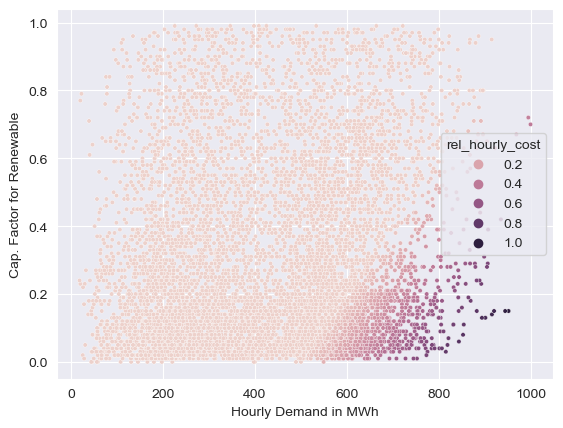

In [35]:

ax = sns.scatterplot(df_input, x='demand', y='cap_factor', hue=df_input['rel_hourly_cost'], s=10)
ax.set_ylabel('Cap. Factor for Renewable')
ax.set_xlabel('Hourly Demand in MWh')
plt.show()
